# Código para calcular las métricas.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, confusion_matrix, confusion_matrix, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

TITULOS = {'fontsize' : 20, 'fontweight' : 'bold'}
SUBTITULOS = {'fontsize' : 16, 'fontweight' : 'bold'}

class Validate():

    def __init__(self, csv_file, dataset="CBIS"):
        self.csv_file = csv_file

        self.validate = pd.read_csv(self.csv_file, delimiter=',', index_col=False)

        if dataset == 'CBIS':
            self.validate = self.validate[['image_file_path', 'breast_density']].sort_values('image_file_path')
            self.validate.columns = ['image', 'label']
        else:
            self.validate = self.validate.loc[(self.validate['machine_id'] == 49) & (self.validate['implant'] == 0)]

            self.validate['image_file_path'] = self.validate['patient_id'].astype(str) + '_' + self.validate['image_id'].astype(str) + '.png'

            self.validate = self.validate[['image_file_path', 'density']].sort_values('image_file_path')

            self.validate.columns = ['image', 'label']

            self.validate.dropna(subset=['label'], inplace=True)

            d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
            self.validate['label'] = self.validate['label'].map(d)
            self.validate['label'].astype(np.int64)


        self.validate.drop_duplicates(inplace=True)
        self.validate.reset_index(drop=True, inplace=True)


    def get_df(self): return self.validate

    def plot_preds_per_class(self):
        plt.figure(figsize=(14, 10))
        plt.suptitle("Distribución dataset", fontdict=TITULOS)

        plt.subplot(1,2,1)
        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Count', fontsize=16)
        plt.bar(self.validate['label'].value_counts().sort_index().index, self.validate['label'].value_counts().sort_index().values)
        plt.xticks(self.validate['label'].value_counts().sort_index().index)

        plt.subplot(1,2,2)
        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Percentage', fontsize=16)
        plt.pie(self.validate['label'].value_counts().sort_index().values, labels=self.validate['label'].value_counts().sort_index().index, autopct='%1.1f%%')

        plt.show()

    def __getitem__(self, key):
        return self.validate[key]


class Predictions():

    def __init__(self, csv_file, dataset="CBIS"):
        self.csv_file = csv_file
        self.dataset = dataset

        # Las predicciones de la CNN
        predictions = pd.read_csv(self.csv_file, delimiter=',', names=['image', "0", "1", "2", "3"])

        #predictions = pd.read_csv(self.csv_file, delimiter=',', index_col=False)#, names = ["image", "0", "1", "2", "3"])
        predictions['label'] = predictions[['0', '1', '2', '3']].idxmax(axis=1)

        # Nos quedamos solo con el nombre de la imagen
        predictions['image'] = predictions['image'].apply(lambda x: x.split('/')[-1])

        # Sumamos uno para que las predicciones esten en el rango [1, 4]
        if dataset == "CBIS":
            predictions['label'] = predictions['label'].apply(lambda x: int(int(x) + 1))
        else:
            predictions['label'] = predictions['label'].apply(lambda x: int(x))

        self.predictions = predictions.sort_values('image')

    def get_df(self): return self.predictions

    def plot_preds_per_class(self):
        plt.figure(figsize=(14, 10))
        plt.suptitle("Distribución predicciones", fontdict=TITULOS)

        plt.subplot(1,2,1)
        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Count', fontsize=16)
        plt.bar(self.predictions['label'].value_counts().sort_index().index, self.predictions['label'].value_counts().sort_index().values)
        plt.xticks(self.predictions['label'].value_counts().sort_index().index)

        plt.subplot(1,2,2)
        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Percentage', fontsize=16)
        plt.pie(self.predictions['label'].value_counts().sort_index().values, labels=self.predictions['label'].value_counts().sort_index().index, autopct='%1.1f%%')

        plt.show()

    def __getitem__(self, key):
        return self.predictions[key]

class TestMetrics():

    def __init__(self, predictions, validate):
        self.predictions = predictions
        self.validate = validate
        self.dataset = self.predictions.dataset

        self.matching_validate = self.validate[self.validate['image'].isin(self.predictions['image'])][['image', 'label']]

        self.compute_predictions()
        self.roc_auc_score = {}
        self.precision = {}

        self.y_bin = None
        self.y_pred = None
        self.recall = None
        self.f1_score = None
        self.acc = None

    def get_matching_validate(self): return self.matching_validate

    def compute_predictions(self):

            # Hacemos un merge para unir la label real desde validate
            merged = self.predictions.get_df().merge(self.matching_validate, on="image", how="left", suffixes=("", "_real"))

            # Comparamos label con label_real y creamos la columna is_correct
            merged["is_correct"] = merged["label"] == merged["label_real"]

            self.predictions.get_df()["is_correct"] = merged.set_index(self.predictions.get_df().index)["is_correct"]

    def accuracy(self):
        """
        Calcula la accuracy por clase y macro accuracy.
        """
        if self.acc is None:
            self.acc = np.zeros(shape=4)
            for i in range(4):
                if self.dataset == "CBIS":
                    self.acc[i] = self.predictions.get_df()[self.predictions.get_df()['label'] == i + 1]['is_correct'].mean()
                else:
                    self.acc[i] = self.predictions.get_df()[self.predictions.get_df()['label'] == i]['is_correct'].mean()

        extra = list(self.acc)
        extra.append(accuracy_score(self.get_y_bin(), self.get_y_pred()))

        #self.acc = extra
        return self.acc, extra

    def get_precision(self):
        """
        Calcula la precision por clase y macro accuracy.
        """
        if not self.precision:
            y_bin = self.get_y_bin()

            y_pred = self.get_y_pred()

            precision_macro = precision_score(y_bin, y_pred, average='macro', zero_division=0)
            precision_micro = precision_score(y_bin, y_pred, average='micro', zero_division=0)
            precision_per_class = precision_score(y_bin, y_pred, average=None, zero_division=0)

            self.precision = {"macro": precision_macro, "micro": precision_micro, "per_class": precision_per_class}

            extra = list(self.precision['per_class'])
            extra.append(self.precision['macro'])

            self.precision['extra'] = extra

        return self.precision

    def get_recall(self):
        if self.recall is None:
            y_bin = self.get_y_bin()

            y_pred = self.get_y_pred()

            self.recall = recall_score(y_bin, y_pred, average=None)

        extra = list(self.recall)
        extra.append(self.recall.mean())

        return self.recall, extra


    def get_f1_score(self):
        if self.f1_score is None:
            self.f1_score = f1_score(self.get_y_bin(), self.get_y_pred(), average=None)

        extra = list(self.f1_score)
        extra.append(self.f1_score.mean())

        return self.f1_score, extra

    def get_roc_auc_score(self):
        if self.roc_auc_score: return self.roc_auc_score

        y_bin = self.get_y_bin()

        y_pred = self.get_y_pred()

        self.roc_auc_score['ovo'] = roc_auc_score(y_bin, self.predictions[['0','1','2','3']], multi_class='ovo', average='macro')
        self.roc_auc_score['ovr'] = roc_auc_score(y_bin, self.predictions[['0','1','2','3']], multi_class='ovr')

        for i in range(4):
            self.roc_auc_score[str(i)] = roc_auc_score(y_bin[:, i], self.predictions[str(i)])

        return self.roc_auc_score

    def roc_auc_curve(self):

        def plot_roc_curve(fpr, tpr, label=None):
            plt.plot(fpr, tpr, linewidth=2, label=label)
            plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
            plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown


        y_bin = self.get_y_bin()

        n_classes = 4

        fpr = dict()
        tpr = dict()

        plt.figure(figsize=(10, 8))

        for i in range(n_classes):

            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], self.predictions[str(i)])
            plot_roc_curve(fpr[i], tpr[i], i)

        plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
        plt.legend()

    def get_precission_recall_curve(self):
        from sklearn.metrics import precision_recall_curve

        def plot_roc_curve(fpr, tpr, label=None):
            plt.plot(fpr, tpr, linewidth=2, label=label)
            plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
            plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown

        y_bin = self.get_y_bin()

        fpr = dict()
        tpr = dict()

        plt.figure(figsize=(14, 10))

        for i in range(4):
            fpr[i], tpr[i], _ = precision_recall_curve(y_bin[:, i], self.predictions[str(i)])
            plot_roc_curve(fpr[i], tpr[i], i)
            #precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)
            #plt.fill_between(fpr[i], tpr[i])

        plt.legend()


    def plot_errors_per_class(self):

        # Barplot con el numero de errores por cada tipo
        fig = plt.figure(figsize=(14, 10))
        #plt.title("Predicciones por clase", fontdict=TITULOS)
        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Nº predicciones | % de error', fontsize=16)

        index = list(range(1, 5))

        sorted_index, sorted_values = _['label'], _['is_correct']
        bar = plt.bar(index, self.predictions.get_df()['label'].value_counts().sort_index().values)
        plt.xticks(index)
        plt.yticks()


        fail_percentage = self.predictions.get_df().groupby('label')['is_correct'].apply(lambda x: (~x).mean() * 100)


        for b, fails in zip(bar, fail_percentage):
            yval = b.get_height()
            plt.text(b.get_x() + b.get_width()/2, yval + 1, f'{fails:.1f}%', ha='center', va='bottom', fontsize=11)

        b = bar[-1]

        plt.text(b.get_x() + b.get_width(), self.predictions['label'].value_counts().values.max() + 5, '% de error', ha='center', va='bottom', fontsize=11)

        plt.legend(['Nº de predicciones'])

        plt.show()


    def plot_num_labels_comparison(self):

        index = np.array(range(1, 5))

        label_counts = self.matching_validate['label'].value_counts().sort_index()
        pred_counts = self.predictions['label'].value_counts().sort_index()

        plt.figure(figsize=(14, 10))
        bar1 = plt.bar(index, label_counts.values, color='skyblue', label='Actual Labels', width=0.4)

        # Bar plot for prediction counts, slightly offset
        bar2 = plt.bar(index + 0.4, pred_counts.values, color='coral', label='Predictions', width=0.4)

        fail_percentage = self.predictions.get_df().groupby('label')['is_correct'].apply(lambda x: (~x).mean() * 100)

        for bar_1, bar_2, fpercentage, label, prediction in zip(bar1, bar2, fail_percentage, label_counts, pred_counts):

            yval = max(bar_1.get_height(), bar_2.get_height())
            x_mid = bar_1.get_x() + bar_1.get_width()

            # Porcentage de accouracy por clase
            plt.text(x_mid, yval + 10, f'{fpercentage:.1f}%', ha='center', va='bottom', fontsize=11)

            # Numero de labels por clase
            plt.text(bar_1.get_x() + bar_1.get_width() / 2, bar_1.get_height() + 5, f'{label}', ha='center', va='bottom', fontsize=11)

            # Numero de predicciones por clase
            plt.text(bar_2.get_x() + bar_2.get_width() / 2, bar_2.get_height() + 5, f'{prediction}', ha='center', va='bottom', fontsize=11)


        plt.xlabel('Breast Density', fontsize=16)
        plt.ylabel('Prediction & Truth COUNT', fontsize=16)
        plt.title('Cantidad de labels vs predicción', TITULOS)
        plt.xticks(index + 0.2, index) # Center x-axis ticks
        plt.yticks(list(range(0, int(max(label_counts.values.max(), pred_counts.values.max())) + 30, int(label_counts.values.max()) // 8)))

        plt.legend()
        plt.grid(axis='y', alpha=0.5) # Add a subtle grid for better readability

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, overall=False, percentage=True):

        conf = confusion_matrix(self.matching_validate['label'], self.predictions['label'])

        title = "Confusion Matrix"

        fmt = 'g'
        if percentage:
            if overall:
                title = "Overall %"
                conf = conf / np.sum(conf)
            else:
                conf = conf / np.sum(conf, axis=0)

            fmt = '.2%'

        plt.figure(figsize=(8, 8))
        #plt.title(title, fontdict=TITULOS)
        ax = sns.heatmap(conf, annot=True, cbar=False, annot_kws={"size": 18},
            fmt=fmt, cmap='Blues')

        ax.set_ylabel("Densidad mamaria", fontdict=SUBTITULOS)
        ax.set_xlabel("Predicción", fontdict=SUBTITULOS)
        plt.show()

    def get_y_bin(self):
        if self.y_bin is None:
            self.y_bin = label_binarize(self.matching_validate['label'], classes=[0,1,2,3] if self.dataset != "CBIS" else [1,2,3,4])
        return self.y_bin

    def get_y_pred(self):
        if self.y_pred is None:
            if self.dataset == "CBIS":
                self.y_pred = label_binarize(self.predictions[['0', '1', '2', '3']].apply(lambda k: int(k.idxmax()) + 1, axis=1), classes=[1,2,3,4])
            else:
                self.y_pred = label_binarize(self.predictions[['0', '1', '2', '3']].apply(lambda k: int(k.idxmax()), axis=1), classes=[0,1,2,3])
        return self.y_pred

    def get_errors_dict(self):
        # Obtén listas únicas de nombres de imagen
        validate_images = set(self.validate['image'])
        prediction_images = set(self.predictions['image'])

        # Imágenes en validate pero NO en predictions
        missing_in_predictions = validate_images - prediction_images

        return {"Lost images" : missing_in_predictions}

    def print_errors_dict(self):
        mdict = self.get_errors_dict()
        return f"Se han perdido {len(mdict['Lost images'])}.\n{mdict}"

In [ ]:
def show_metrics(predictions_csv : str, dataset = "CBIS"):
    predictions = Predictions(predictions_csv, dataset)
    validate = Validate('all_test.csv') if dataset == "CBIS" else Validate('train_RSNA.csv', dataset)
    testMetrics = TestMetrics(predictions, validate)


    print(f"Accuracy:\t\t", testMetrics.accuracy())
    print(f"ROC AUC score ovo:\t", testMetrics.get_roc_auc_score()['ovo'])
    print(f"ROC AUC score ovr:\t", testMetrics.get_roc_auc_score()['ovr'])
    print(f"Preccision micro:\t", testMetrics.get_precision()['micro'])
    print(f"Preccision macro:\t", testMetrics.get_precision()['macro'])
    print(f"Preccision per class:\t", testMetrics.get_precision()['per_class'])

    testMetrics.roc_auc_curve()

    testMetrics.plot_confusion_matrix(percentage=False)

# Muestra de los calculos del codigo.

Accuracy:		 (array([0.44347826, 0.71138211, 0.65816327, 0.62307692]), [np.float64(0.4434782608695652), np.float64(0.7113821138211383), np.float64(0.6581632653061225), np.float64(0.6230769230769231), 0.6346433770014556])
ROC AUC score ovo:	 0.881783516062027
ROC AUC score ovr:	 0.881783516062027
Preccision micro:	 0.6346433770014556
Preccision macro:	 0.6090251407684373
Preccision per class:	 [0.44347826 0.71138211 0.65816327 0.62307692]


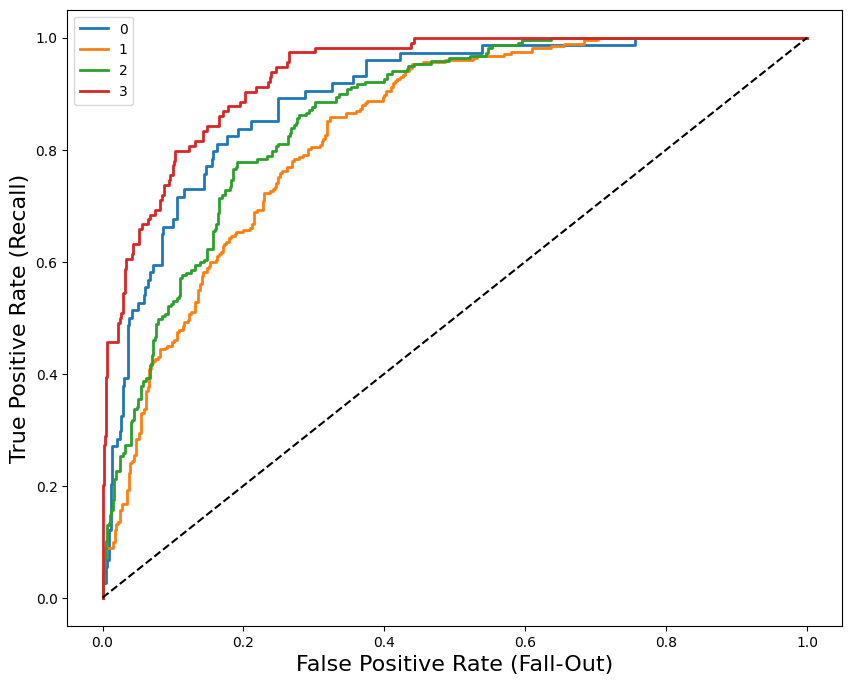

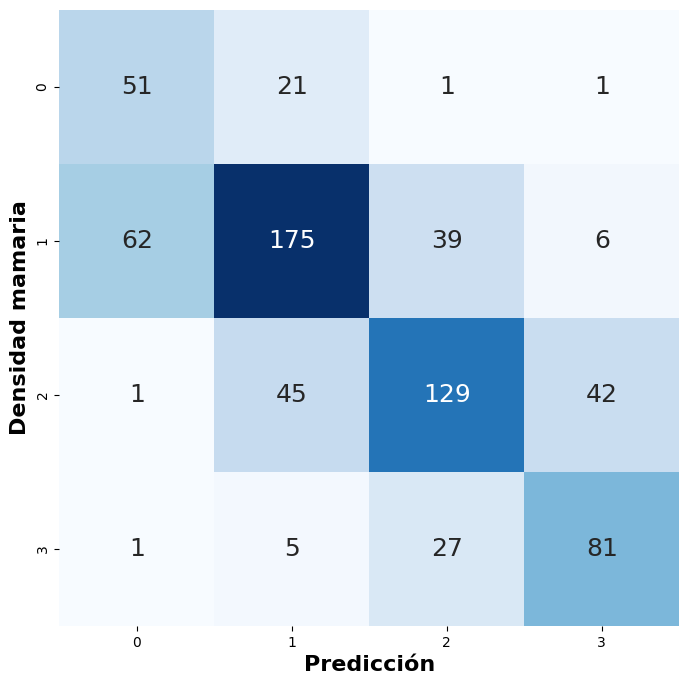

In [ ]:
show_metrics('DA_CBIS.csv', dataset="CBIS")

Accuracy:		 (array([0.62923729, 0.71927237, 0.77319005, 0.78205128]), [np.float64(0.6292372881355932), np.float64(0.7192723697148475), np.float64(0.7731900452488688), np.float64(0.782051282051282), 0.7334085778781039])
ROC AUC score ovo:	 0.904950600161536
ROC AUC score ovr:	 0.904950600161536
Preccision micro:	 0.7334085778781039
Preccision macro:	 0.7259377462876478
Preccision per class:	 [0.62923729 0.71927237 0.77319005 0.78205128]


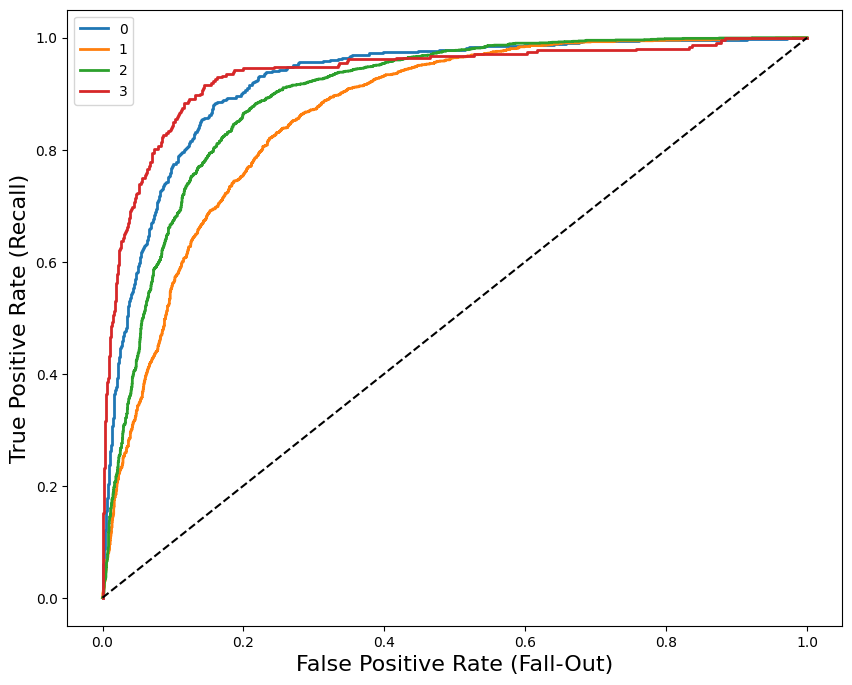

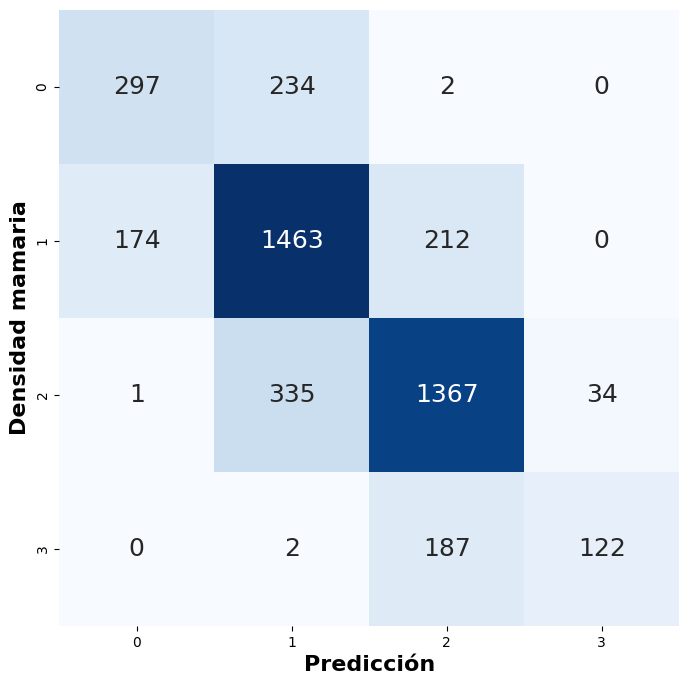

In [ ]:
show_metrics('DA.csv', dataset="RSNA")

In [ ]:
t = TestMetrics(Predictions("DA.csv", dataset="RSNA"), Validate("train_RSNA.csv", dataset="RSNA"))

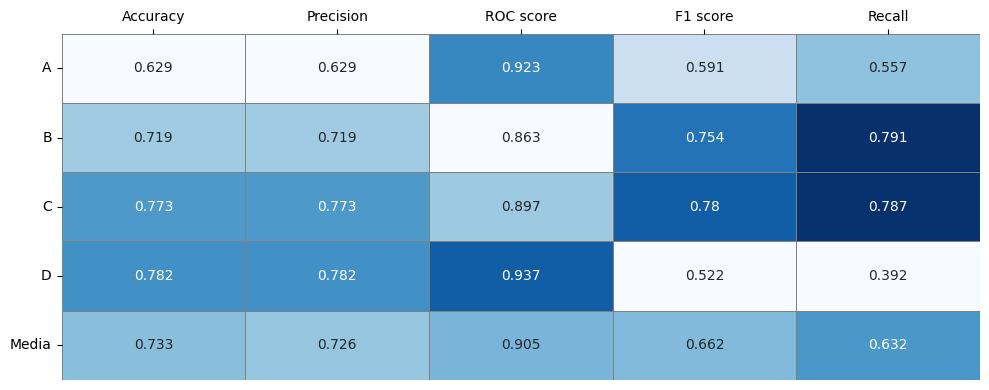

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

r = t.get_roc_auc_score()
rr = [r[str(i)] for i in range(4)]
rr.append(r['ovr'])

# Datos reales
df_real = pd.DataFrame({
    "Accuracy": [round(i, 3) for i in t.accuracy()[-1]],
    "Precision": [round(i, 3) for i in t.get_precision()['extra']],
    "ROC score": [round(i, 3) for i in rr],
    "F1 score": [round(i, 3) for i in t.get_f1_score()[1]],
    "Recall": [round(i, 3) for i in t.get_recall()[1]],
}, index=["A", "B", "C", "D", "Media"])


# Normalizar cada columna por separado para el color
df_colors = df_real.astype(float).copy()
df_colors = (df_colors - df_colors.min()) / (1.0 - df_colors.min())

# Mostrar valores reales
df_display = df_real.astype(str)

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(
    df_colors,             # datos normalizados por columna
    annot=df_display,      # anotaciones reales
    fmt="s",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    #annot_kws={"color": "black"}
)

plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


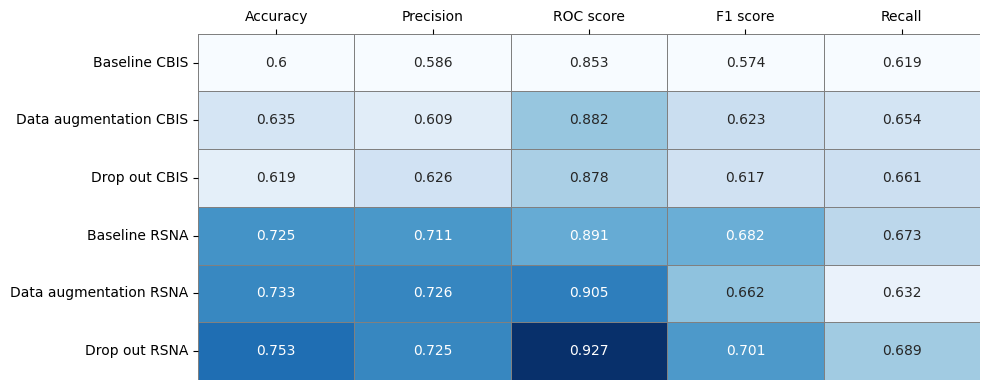

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


tt = [
    TestMetrics(Predictions("baseline_CBIS.csv"),                   Validate("all_test.csv")),
    TestMetrics(Predictions("DA_CBIS.csv"),                         Validate("all_test.csv")),
    TestMetrics(Predictions("DADO_CBIS.csv"),                       Validate("all_test.csv")),

    TestMetrics(Predictions("baseline_pred.csv", dataset="RSNA"),   Validate("train_RSNA.csv", dataset="RSNA")),
    TestMetrics(Predictions("DA.csv", dataset="RSNA"),              Validate("train_RSNA.csv", dataset="RSNA")),
    TestMetrics(Predictions("DADO.csv", dataset="RSNA"),            Validate("train_RSNA.csv", dataset="RSNA")),
]

# Datos reales
df_real = pd.DataFrame({
    "Accuracy": [round(i.accuracy()[1][-1], 3) for i in tt],
    "Precision": [round(i.get_precision()['extra'][-1], 3) for i in tt],
    "ROC score": [round(i.get_roc_auc_score()['ovr'], 3) for i in tt],
    "F1 score": [round(i.get_f1_score()[1][-1], 3) for i in tt],
    "Recall": [round(i.get_recall()[1][-1], 3) for i in tt],
}, index=["Baseline CBIS", "Data augmentation CBIS", "Drop out CBIS", "Baseline RSNA","Data augmentation RSNA", "Drop out RSNA"])


# Normalizar cada columna por separado para el color
df_colors = df_real.astype(float).copy()
df_colors = (df_colors - df_colors.min()) / (1.0 - df_colors.min())

# Mostrar valores reales
df_display = df_real.astype(str)

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(
    df_colors,             # datos normalizados por columna
    annot=df_display,      # anotaciones reales
    fmt="s",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    #annot_kws={"color": "black"}
)

plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
